# A4

The Traveling Salesman Problem (TSP)
The TSP tries to answer the following question: "Given a list of cities and the distances
between each pair of cities, what is the shortest possible route that visits each city exactly
once and returns to the origin city?”
The input of the problema is a list of cities and their connections, usually in a graph
format, and the expected output is a list that contains the cities ordered accoring to their
visit order, which is supposed to minimize the total traveling time between them.

## Genetic algorithm

Given the network of cities G, any vector S may be seen as the chromosome
corresponding to the route that travels across all the nodes of G. The objective is the
implementation of a genetic algorithm to obtain the vector that minimizes the total time.

## Imports

In [1]:
%matplotlib inline 

import random
import time
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint as print 

## Convenience Classes

### City

The City class, which represents a city, possesses the properties of the city and has functions/ methods used for calculating the distance between the city and another city. Each path, represented by a chromosome, is formed by a set of cities.   

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

### Fitness

The Fitness class, which represents the fitness function, possesses the properties of a path and has functions/methods used for calculating the fitness value of the path, which is based on the distance of the path. 

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = None
        self.fitness = None
    
    def routeDistance(self):
        if self.distance == None:
            pathDistance = 0.0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i+1 < len(self.route):
                    toCity = self.route[i+1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == None:
        # Fitness function (Simple division) that uses a simple 
        # division that divides one by the distance of the path
            if self.routeDistance() != 0:
                self.fitness = 1 / float(self.routeDistance()) 
                # Note: You must ensure a division by zero does not occur 
        return self.fitness


## Population Initialization  

The population initialization function (or method) performs random initialization. This creates an initial population with completely random chromosomes (or solutions). There are three functions related to population initialization. 

The first function is genCityList() which generates a set of cities from a file.  

In [4]:
def genCityList(filename):
    cityList = []
    
    with open(filename, 'r') as file:
        for line in file:
            _, x, y = line.split()  # Разделение строки на части, игнорирование первого элемента
            cityList.append(City(x=float(x), y=float(y)))
    
    return cityList


In [5]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [6]:
def initialPopulation(popSize, cityList):
    population = []
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [8]:
cityList = genCityList('cities10.txt') 
print(cityList)

[(30133.3333,57633.3333),
 (30166.6667,57100.0),
 (30233.3333,57583.3333),
 (30250.0,56850.0),
 (30250.0,56950.0),
 (30250.0,57583.3333),
 (30300.0,56966.6667),
 (30316.6667,56816.6667),
 (30400.0,56466.6667),
 (30400.0,56783.3333)]


Sample run 2 initializes 10 cities in cityList and creates a population with three routes as follows:

In [10]:
cityList = genCityList('cities10.txt') 
population = initialPopulation(3, cityList) 
print(population)

[[(30133.3333,57633.3333),
  (30233.3333,57583.3333),
  (30316.6667,56816.6667),
  (30250.0,56850.0),
  (30250.0,57583.3333),
  (30166.6667,57100.0),
  (30300.0,56966.6667),
  (30250.0,56950.0),
  (30400.0,56783.3333),
  (30400.0,56466.6667)],
 [(30316.6667,56816.6667),
  (30133.3333,57633.3333),
  (30250.0,56950.0),
  (30166.6667,57100.0),
  (30400.0,56466.6667),
  (30300.0,56966.6667),
  (30250.0,56850.0),
  (30400.0,56783.3333),
  (30233.3333,57583.3333),
  (30250.0,57583.3333)],
 [(30400.0,56466.6667),
  (30316.6667,56816.6667),
  (30250.0,56950.0),
  (30233.3333,57583.3333),
  (30400.0,56783.3333),
  (30250.0,56850.0),
  (30300.0,56966.6667),
  (30133.3333,57633.3333),
  (30250.0,57583.3333),
  (30166.6667,57100.0)]]


## Selection

Parents selection selects chromosomes with high fitness values from a population. Survivor selection selects chromosomes with higher fitness values to form the population of the next generation. The population size is len(population), so we have len(population) in this population. 

### Parent Selection



In [14]:
def tournamentSelection(population, poolSize=None, tournamentSize=3):
    if poolSize == None:
        poolSize = len(population)
        
    matingPool = []
    
   for _ in range(poolSize):
   tournament = random.sample(population, tournamentSize)
          bestIndividual = max(tournament, key=lambda individual: individual.fitness)
    matingPool.append(bestIndividual)
    return matingPool

In [15]:
def stochasticUniversalSampling(population, poolSize=None):
    # Set the pool size to the length of the population if not specified
    if poolSize is None:
        poolSize = len(population)
    
    # Initialize the mating pool
    matingPool = []
    
    # Implementing Stochastic Universal Sampling
    stepSize = 1.0 / poolSize
    pointer = random.uniform(0, stepSize)
    total = 0
    for individual in population:
        total += individual.fitness
        while pointer <= total:
            matingPool.append(individual)
            pointer += stepSize

    # Truncate the mating pool to the desired pool size
    matingPool = matingPool[:poolSize]
    
    return matingPool



### Survival Selection

In [16]:
def survivorSelection(population, eliteSize):

    elites = []
    
    for i in range(eliteSize):
        elites.append(population[i])
    
    return elites

 initializes 10 cities in cityList, creates a population with four routes, select an elite chromosome as follows:

In [18]:
population = initialPopulation(4, genCityList('cities10.txt'))
elites = survivorSelection(population, 1)
print('Initial population')
print(population)
print('Selected elites')
print(elites)

'Initial population'
[[(30316.6667,56816.6667),
  (30233.3333,57583.3333),
  (30166.6667,57100.0),
  (30300.0,56966.6667),
  (30250.0,56950.0),
  (30400.0,56783.3333),
  (30250.0,57583.3333),
  (30250.0,56850.0),
  (30400.0,56466.6667),
  (30133.3333,57633.3333)],
 [(30250.0,56850.0),
  (30250.0,56950.0),
  (30250.0,57583.3333),
  (30400.0,56783.3333),
  (30166.6667,57100.0),
  (30133.3333,57633.3333),
  (30300.0,56966.6667),
  (30233.3333,57583.3333),
  (30316.6667,56816.6667),
  (30400.0,56466.6667)],
 [(30166.6667,57100.0),
  (30400.0,56466.6667),
  (30250.0,56950.0),
  (30316.6667,56816.6667),
  (30133.3333,57633.3333),
  (30233.3333,57583.3333),
  (30250.0,57583.3333),
  (30400.0,56783.3333),
  (30250.0,56850.0),
  (30300.0,56966.6667)],
 [(30250.0,57583.3333),
  (30400.0,56783.3333),
  (30250.0,56850.0),
  (30300.0,56966.6667),
  (30316.6667,56816.6667),
  (30400.0,56466.6667),
  (30233.3333,57583.3333),
  (30133.3333,57633.3333),
  (30166.6667,57100.0),
  (30250.0,56950.0)]]
'Se

## Crossover


In [19]:
def insertGene(insert, insert_index, child1, child2, fixed_child1, fixed_child2):
    # print("(" + str(insert) + ", " + str(insert_index) + ", " + str(child1) + ", " + str(child2) + ")")

    insert_in_child1 = insert in fixed_child1
    if insert_in_child1 == False:
        child1.insert(insert_index, insert)
    else:
        found_index = fixed_child1.index(insert)
        insert = fixed_child2[found_index]
        return insertGene(insert, insert_index, child1, child2, fixed_child1, fixed_child2)

In [20]:
parent1 = [2,1,0,7,3,5,4,6]
parent2 = [6,1,0,5,2,3,4,7]

print(parent1)
print(parent2)

child1 = parent2[2:6] # 2-5
child2 = parent1[2:6] # 2-5

for i in range(0, 2): # 0-1
    insertGene(parent1[i], i, child1, child2, child1, child2)
for i in range(6, 8): # 6-7
    insertGene(parent1[i], i, child1, child2, child1, child2)

for i in range(0, 2): # 0-1
    insertGene(parent2[i], i, child2, child1, child2, child1)
for i in range(6, 8): # 6-7
    insertGene(parent2[i], i, child2, child1, child2, child1)

print(child1)
print(child2)

[2, 1, 0, 7, 3, 5, 4, 6]
[6, 1, 0, 5, 2, 3, 4, 7]
[7, 1, 0, 5, 2, 3, 4, 6]
[6, 1, 0, 7, 3, 5, 4, 2]


In [21]:
import random as rd

def crossover(parent1, parent2):
    first_crossover = rd.randint(0, len(parent1)-1)
    second_crossover = rd.randint(0, len(parent1)-1)
    while second_crossover - first_crossover != 2:
        first_crossover = rd.randint(0, len(parent1)-1)
        second_crossover = rd.randint(0, len(parent1)-1)
    # print("Crossovers: " + str(first_crossover) + ", " + str(second_crossover))
        
    # swap the genes between the crossover
    child2 = parent1[first_crossover : second_crossover+1]
    child1 = parent2[first_crossover : second_crossover+1]
    fixed_child1 = child1.copy()
    fixed_child2 = child2.copy()
    
    # fill in the rest of the genes
    for i in range(0, first_crossover):
        insertGene(parent1[i], i, child1, child2, fixed_child1, fixed_child2)
    for i in range(second_crossover+1, len(parent1)):
        insertGene(parent1[i], i, child1, child2, fixed_child1, fixed_child2)
        
    for i in range(0, first_crossover):
        insertGene(parent2[i], i, child2, child1, fixed_child2, fixed_child1)
    for i in range(second_crossover+1, len(parent1)):
        insertGene(parent2[i], i, child2, child1, fixed_child2, fixed_child1)
    
    return child1, child2

In [22]:
parent1 = [2,1,0,7,3,5,4,6]
parent2 = [6,1,0,5,2,3,4,7]
print(parent1)
print(parent2)
child1, child2 = crossover(parent1, parent2)
print(child1)
print(child2)

[2, 1, 0, 7, 3, 5, 4, 6]
[6, 1, 0, 5, 2, 3, 4, 7]
[2, 1, 0, 5, 3, 7, 4, 6]
[6, 1, 0, 7, 2, 3, 4, 5]


## Mutation

In [26]:
def mutate(route, mutationProbability):
    mutated_route = route[:]
    for i in range(0,len(route)):
        if (rd.random() < mutationProbability):

            current_gene = route[i]
            rand_insert_index = rd.randint(0, len(route)-1)            
            mutated_route.remove(current_gene)
            mutated_route.insert(rand_insert_index, current_gene)
    
    return mutated_route

Mutation runs over the entire population and mutates each chromosome in the population with a small mutationProbability. 

In [27]:
def mutation(population, mutationProbability):
    mutatedPopulation = []
    for i in range(0, len(population)):
        mutatedIndividual = mutate(population[i], mutationProbability)
        mutatedPopulation.append(mutatedIndividual)
    return mutatedPopulation

In [28]:
route = [1,2,3,4,5,6,7,8,9,10]
route2 = [10,9,8,7,6,5,4,3,2,1]
population = [route, route2]

mutatedPopulation = mutation(population, 0.1)
print(mutatedPopulation)

[[1, 2, 3, 5, 4, 6, 7, 8, 9, 10], [9, 8, 7, 6, 4, 3, 10, 5, 2, 1]]


The sample run initializes a route comprised of 10 cities in cityList, and then mutates it as follows:

In [29]:
route = genCityList('cities10.txt')
mutated = mutate(route, 1)  # Give a pretty high chance for mutation
print('Original route')
print(route)
print('Mutated route')
print(mutated)

'Original route'
[(30133.3333,57633.3333),
 (30166.6667,57100.0),
 (30233.3333,57583.3333),
 (30250.0,56850.0),
 (30250.0,56950.0),
 (30250.0,57583.3333),
 (30300.0,56966.6667),
 (30316.6667,56816.6667),
 (30400.0,56466.6667),
 (30400.0,56783.3333)]
'Mutated route'
[(30133.3333,57633.3333),
 (30400.0,56466.6667),
 (30233.3333,57583.3333),
 (30250.0,57583.3333),
 (30300.0,56966.6667),
 (30166.6667,57100.0),
 (30250.0,56950.0),
 (30316.6667,56816.6667),
 (30250.0,56850.0),
 (30400.0,56783.3333)]


## Running One Generation (or Interation)

Here, we run one generation of genetic algorithm. 

In [17]:
def oneGeneration(population, eliteSize, mutationProbability):
    
    # First we preserve the elites
    elites = survivorSelection(population, eliteSize)
    
    # Then we calculate what our mating pool size should be and generate
    # the mating pool
    poolSize = len(population) - eliteSize
    matingpool = parentSelection(population, poolSize)
        
    
    # We combine the elites and children into one population
    new_population = elites + children
    
    # We mutate the population
    mutated_population = mutation(new_population, mutationProbability)
        
    return mutated_population

 The sample run initializes a population comprised of 5 chromosomes based on 10 cities in cityList, and then run one generation (or iteration) of genetic algorithm as follows:

population = initialPopulation(5, genCityList('cities10.txt'))
eliteSize = 1
mutationProbability = 0.01
new_population = oneGeneration(population, eliteSize, mutationProbability)
print('Initial population')
print(population)
print('New population')
print(new_population)

## Running Many Generations (or Interations) 

In [32]:
filename = 'cities10.txt'
popSize = 20
eliteSize = 5
mutationProbability = 0.01
iteration_limit = 1000

cityList = genCityList(filename)

population = initialPopulation(popSize, cityList)
distances = [Fitness(p).routeDistance() for p in population]
min_dist = min(distances)
print("Best distance for initial population: " + str(min_dist))

for i in range(iteration_limit):
    population = oneGeneration(population, eliteSize, mutationProbability)
    distances = [Fitness(p).routeDistance() for p in population]
    index = np.argmin(distances)
    best_route = population[index]
    min_dist = min(distances)
    # print("Best distance for population in iteration " + str(i) +
    #       ": " + str(min_dist))

print("Optimal path is " + str(best_route)) 

'Best distance for initial population: 2772.5177530424576'
('Optimal path is [(30250.0,57583.3333), (30133.3333,57633.3333), '
 '(30233.3333,57583.3333), (30400.0,56783.3333), (30400.0,56466.6667), '
 '(30250.0,56850.0), (30166.6667,57100.0), (30300.0,56966.6667), '
 '(30250.0,56950.0), (30316.6667,56816.6667)]')


In [37]:
# Converting to a numpy array and normalizing
points = np.array(coordinates)
points = (points - points.min(axis=0)) / (points.max(axis=0) - points.min(axis=0))


In [40]:
# Simple generic algorithm for TSP
for _ in range(1000):  # Number of iterations
    # Generate two indices to swap
    i, j = random.sample(range(num_cities), 2)
    new_path = path.copy()
    new_path[i], new_path[j] = new_path[j], new_path[i]

    # If the new path is better, accept it
    if total_distance(new_path, points) < total_distance(path, points):
        path = new_path


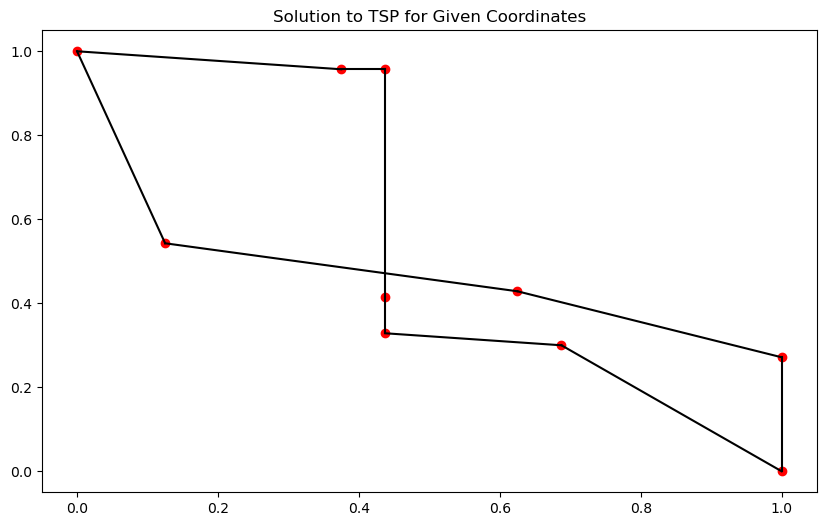

In [41]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(points[:, 0], points[:, 1], 'o', color='red')  # Cities

# Draw the path
for i in range(num_cities):
    start_point = points[path[i-1]]
    end_point = points[path[i]]
    plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k-')

plt.title('Solution to TSP for Given Coordinates')
plt.show()

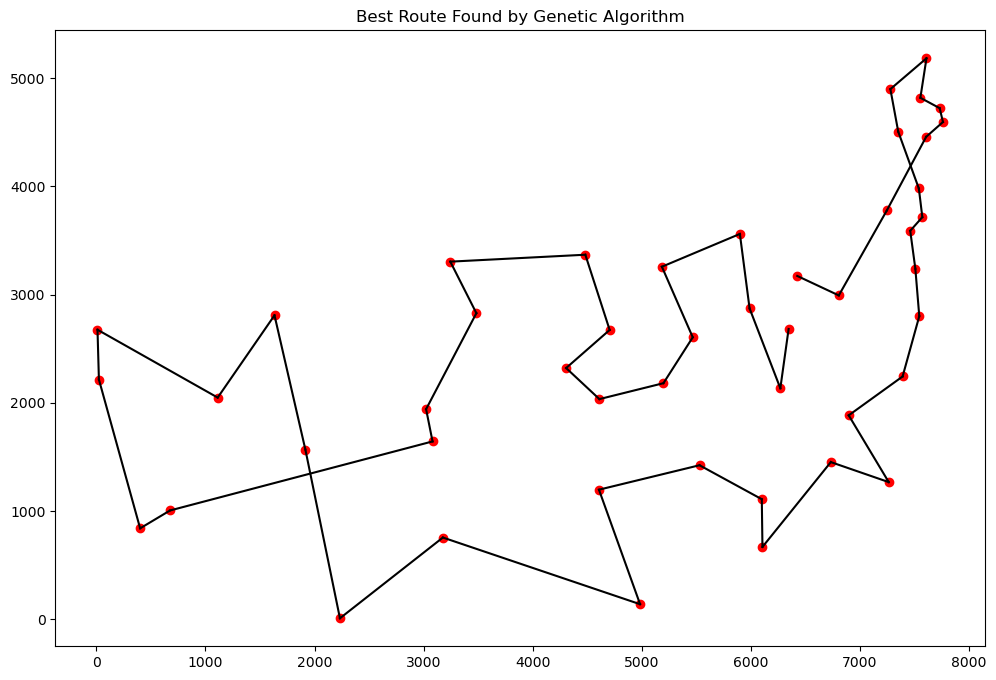

In [49]:
# Visualization of the best route
plt.figure(figsize=(12, 8))
plt.plot(points_array[:, 0], points_array[:, 1], 'o', color='red')  # Cities

# Draw the best path
for i in range(1, len(best_route)):
    start_point = points_array[best_route[i-1]]
    end_point = points_array[best_route[i]]
    plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k-')

plt.title('Best Route Found by Genetic Algorithm')
plt.show()

